(c) [Julius Hense](https://github.com/hense96) & [Mina Jamshidi](https://github.com/minajamshidi) @ TU Berlin, 2024

(c) This notebook is an asset of xMIL: https://github.com/tubml-pathology/xMIL

Please note the license and citation instructions as described in the above repository.

---

# Conservation check of xMIL-LRP

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [2]:
import os
import json
import argparse
from collections import defaultdict
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from training.callback import Callback
from models.model_factory import ModelFactory, xModelFactory
from datasets.dataset_factory import DatasetFactory
from xai.evaluation import xMILEval

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
proj_name = 'nsclc'
model_name = 'transmil'

results_dir_parent = '/home/mina/codes/my_codes/Digital_Pathology/xMIL/results'
model_path = os.path.join(results_dir_parent, 'trained_models', proj_name, model_name)
model_path

'/home/mina/codes/my_codes/Digital_Pathology/xMIL/results/trained_models/nsclc/transmil'

In [5]:
with open(os.path.join(model_path, 'args.json')) as f:
    args_model = json.load(f)

In [6]:
args_model

{'split_path': '/home/space/datasets/tcga/splits/tcga_nsclc_study_60_15_25_0.csv',
 'metadata_dirs': ['/home/space/datasets/tcga/luad/metadata/v001',
  '/home/space/datasets/tcga/lusc/metadata/v001'],
 'patches_dirs': ['/home/space/datasets/tcga/luad/patches/20x',
  '/home/space/datasets/tcga/lusc/patches/20x'],
 'features_dirs': ['/home/space/datasets/tcga/luad/features/20x/ctranspath_pt',
  '/home/space/datasets/tcga/lusc/features/20x/ctranspath_pt'],
 'results_dir': '/home/juliush/results/xMIL/models/hopt_v3/nsclc/transmil/19',
 'model_param_path': None,
 'train_subsets': ['train'],
 'val_subsets': ['val'],
 'test_subsets': ['test'],
 'balance_key': None,
 'sampler': None,
 'drop_duplicates': 'sample',
 'patch_filters': None,
 'train_bag_size': 2048,
 'max_bag_size': 24000,
 'preload_data': True,
 'aggregation_model': 'transmil',
 'input_dim': 768,
 'num_classes': 2,
 'targets': ['label'],
 'no_bias': False,
 'additive': False,
 'n_out_layers': 0,
 'features_dim': 256,
 'inner_atten

In [9]:
dataset = 'test'
sel_checkpoint = 'best'
max_bag_size = 10000

In [10]:
# load the data_loader of interest based on the user argument args_user.dataset
none_datasets = [f'{set_name}_subsets' for set_name in ['train', 'val', 'test'] if set_name != dataset]
for set_name in none_datasets:
    args_model[set_name] = None
    
_, train_loader, _, val_loader, _, test_loader = DatasetFactory.build(args_model, args_model)

data_loader = [loader for loader in [train_loader, val_loader, test_loader] if loader is not None][0]

   

Loading dataset for subsets: ['test']
Loading patch metadata


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:24<00:00, 10.32it/s]


Dropping 14 slides with more than 24000 patches.
Loading features into RAM


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:32<00:00,  7.22it/s]


In [11]:
 # define callback, model, classifier, xmodel
callback = Callback(
        schedule_lr=args_model['schedule_lr'], checkpoint_epoch=1, path_checkpoints=model_path,
        early_stop=args_model['early_stopping'], device=device)
model, classifier = ModelFactory.build(args_model, device)
model = callback.load_checkpoint(model, checkpoint=sel_checkpoint)
xmodel = xModelFactory.build(model, dict())


In [12]:
# collect the relevance dictionaries of the explanations
rel_dicts = []
for batch in data_loader:
    if batch['bag_size'].item() <= max_bag_size:
        _ , rel_dict, _ = xmodel.explain_lrp(batch)
        rel_dicts.append(rel_dict)
    

In [14]:
# sum up the relevance scores in each layer

rel_sum = defaultdict(list)
for rel_dict in rel_dicts:
    for layer, relevance in rel_dict.items():
        if layer == 'fc1':
            # for the fc1 layer, we also add the relevance of the class token to check the relevance conservation
            cls_token_rel = rel_dict['translayer-0'][:, 0].sum().item()
            rel_sum[layer].append(cls_token_rel + relevance.sum().item())
        else:
            rel_sum[layer].append(relevance.sum().item())
        

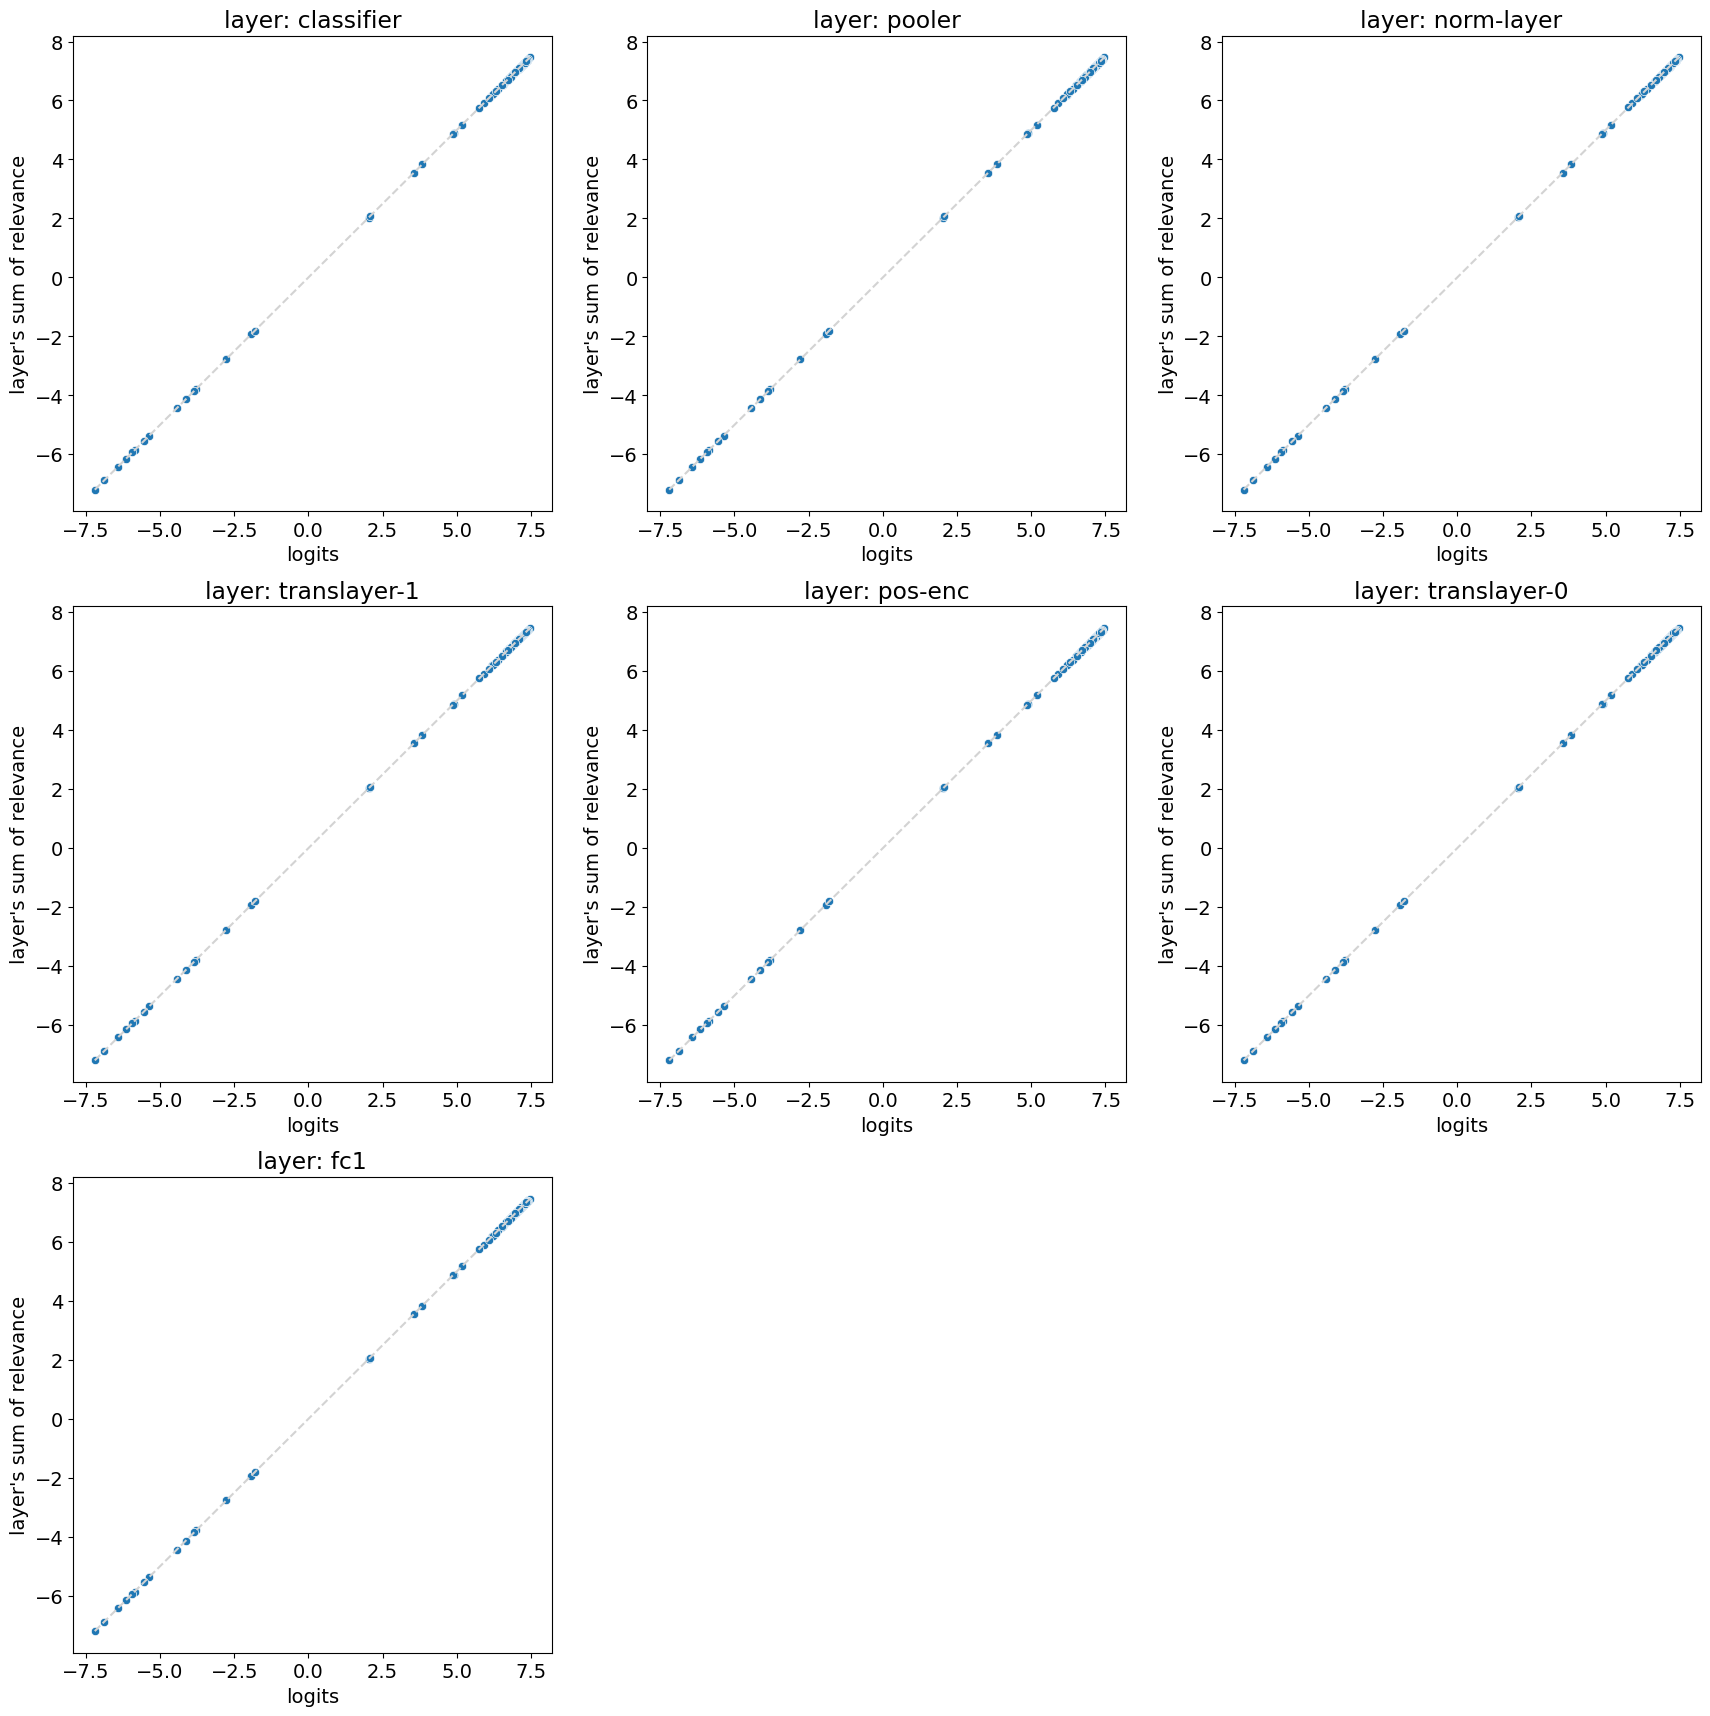

In [16]:
# plot the the relevance sum of each layer vs the output relevance

plt.rcParams.update({'font.size': 14})

n_keys = len(rel_sum.keys())-1
n1 = 3
n2 = n_keys // n1 + n_keys % n1
fig, axes = plt.subplots(n2, n1, figsize=(7*n1, 7*n2)) 

axes = axes.flatten()
layer_keys = list(rel_sum.keys())[1:]
for ax, layer_key in zip(axes[:len(layer_keys)], layer_keys):
    x = rel_sum['out']
    y = rel_sum[layer_key]
    ax.plot([min(x), max(x)], [min(x), max(x)], color='lightgray', linestyle='--')
    ax.set_xlabel('logits')
    ax.set_ylabel("layer's sum of relevance")
    sns.scatterplot(x=x, y=y, ax=ax)
    ax.set_title(f'layer: {layer_key}')
    
for ax in axes[n_keys:]:
    ax.axis('off')
    